Vision Transformer (ViT) Analysis
Model: google/vit-base-patch16-224
Device: cuda

----------------------------------------------------------------------
✓ Image 1 downloaded: image_1.jpg
✓ Image 2 downloaded: image_2.jpg
✓ Image 3 downloaded: image_3.jpg
----------------------------------------------------------------------

Loading Vision Transformer: google/vit-base-patch16-224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Model loaded successfully

TASK 1: Image Classification with Pretrained ViT

Image 1: image_1.jpg
  Top-1 prediction: 'Labrador retriever' (confidence: 0.5786)
  Expected: Dog image: Should predict a dog breed (e.g., 'golden retriever')

Image 2: image_2.jpg
  Top-1 prediction: 'sports car, sport car' (confidence: 0.8898)
  Expected: Car image: Should predict a vehicle (e.g., 'sports car')

Image 3: image_3.jpg
  Top-1 prediction: 'Granny Smith' (confidence: 0.8507)
  Expected: Apple image: Should predict an apple variety (e.g., 'Granny Smith')


Loading Vision Transformer: google/vit-base-patch16-224


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Model loaded successfully

TASK 2: Attention Map Visualization

Analyzing: image_1.jpg
Prediction: 'Labrador retriever' (confidence: 0.5786)

Attention Statistics:
  Shape: (14, 14)
  Min: 0.0002, Max: 0.0611
  Mean: 0.0051, Std: 0.0103
Figure saved: attention_1.png


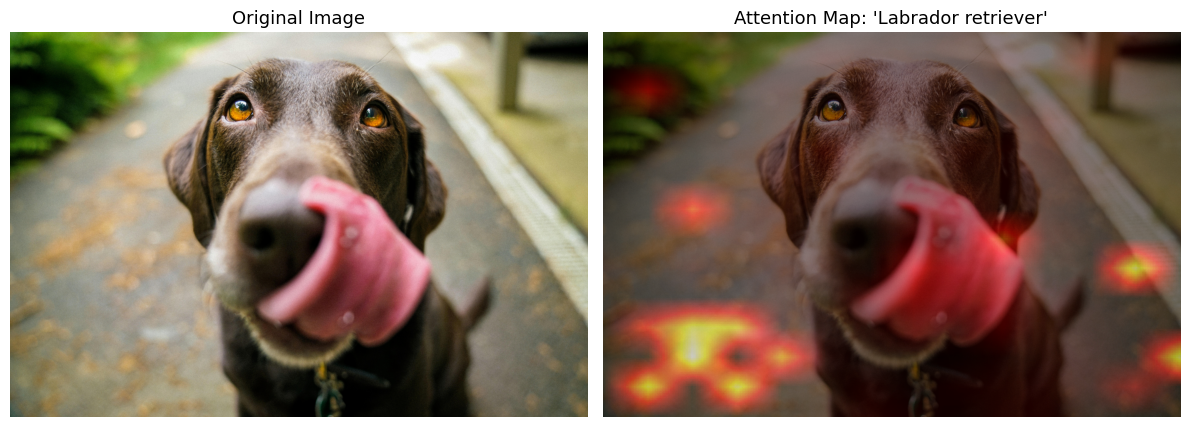


Attention Map Analysis:
  - Red areas indicate high attention (important for prediction)
  - Check if model focuses on relevant object features
  - Background attention may indicate context dependence

TASK 3: Patch Masking Experiments

Testing: image_1.jpg
Original prediction: 'Labrador retriever' (confidence: 0.5786)

[1] Contiguous Patch Masking (20 patches):
  Masked prediction: 'Labrador retriever' (confidence: 0.7455)
  Prediction changed: False

[2] Random Patch Masking (20 patches):
  Masked prediction: 'Labrador retriever' (confidence: 0.7046)
  Prediction changed: False

Robustness Analysis:
  Contiguous masking: -0.1669 confidence drop
  Random masking: -0.1260 confidence drop
  → Model is more robust to contiguous occlusions

Loading ViT feature extractor: google/vit-base-patch16-224


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: google/vit-base-patch16-224
Key                 | Status     | 
--------------------+------------+-
classifier.bias     | UNEXPECTED | 
classifier.weight   | UNEXPECTED | 
pooler.dense.bias   | MISSING    | 
pooler.dense.weight | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Feature extractor loaded successfully

TASK 4: Linear Probing of ViT Representations

Dataset: 3 images
Labels: [0, 1, 2]

Extracting features...
  Image 1: CLS shape torch.Size([1, 768]), Patches shape torch.Size([1, 768])
  Image 2: CLS shape torch.Size([1, 768]), Patches shape torch.Size([1, 768])
  Image 3: CLS shape torch.Size([1, 768]), Patches shape torch.Size([1, 768])

Final feature shapes:
  CLS tokens: (3, 768)
  Patch tokens: (3, 768)

----------------------------------------------------------------------
Training Linear Probes (3-fold Cross-Validation)
----------------------------------------------------------------------

[CLS Token Probe]
  Fold 1: 0.0000
  Fold 2: 0.0000
  Fold 3: 0.0000
  Mean Accuracy: 0.0000

[Patch Token Probe]
  Fold 1: 0.0000
  Fold 2: 0.0000
  Fold 3: 0.0000
  Mean Accuracy: 0.0000

----------------------------------------------------------------------
Comparison:
  CLS Token Accuracy:   0.0000
  Patch Token Accuracy: 0.0000
  → Pooled patch toke

In [2]:
"""
Vision Transformer (ViT) Analysis
This script explores Vision Transformers through:
1. Image classification with pretrained ViT
2. Attention map visualization
3. Patch masking experiments
4. Linear probing of representations
"""

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from PIL import Image
from scipy.ndimage import zoom
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel


# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Configuration parameters for ViT analysis"""
    model_name = 'google/vit-base-patch16-224'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    random_seed = 42

    # Image URLs for testing
    image_urls = [
        "https://images.unsplash.com/photo-1518717758536-85ae29035b6d",  # Dog
        "https://images.unsplash.com/photo-1502877338535-766e1452684a",  # Car
        "https://images.pexels.com/photos/102104/pexels-photo-102104.jpeg"  # Apple
    ]

    image_descriptions = [
        "Dog image: Should predict a dog breed (e.g., 'golden retriever')",
        "Car image: Should predict a vehicle (e.g., 'sports car')",
        "Apple image: Should predict an apple variety (e.g., 'Granny Smith')"
    ]

    # Patch parameters
    image_size = 224
    patch_size = 16
    num_patches = (image_size // patch_size) ** 2  # 196 patches (14x14)
    grid_size = image_size // patch_size  # 14

    # Probing parameters
    n_folds = 3
    max_iter_lr = 1000


# ============================================================================
# Image Loading and Preprocessing
# ============================================================================

def download_images(urls, save_prefix="image", timeout=10):
    """
    Download images from URLs and save locally

    Args:
        urls: List of image URLs
        save_prefix: Prefix for saved image files
        timeout: Request timeout in seconds

    Returns:
        saved_paths: List of saved image paths
    """
    saved_paths = []

    print("\nDownloading images...")
    print("-" * 70)

    for i, url in enumerate(urls):
        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(url, stream=True, headers=headers, timeout=timeout)

            content_type = response.headers.get('content-type', '')
            if 'image' not in content_type:
                raise ValueError(f"URL returned non-image content: {content_type}")

            image = Image.open(io.BytesIO(response.content)).convert('RGB')
            filename = f"{save_prefix}_{i+1}.jpg"
            image.save(filename)
            saved_paths.append(filename)

            print(f"✓ Image {i+1} downloaded: {filename}")

        except Exception as e:
            print(f"✗ Error downloading image {i+1} ({url}): {str(e)}")
            print(f"  Try downloading manually and saving as {save_prefix}_{i+1}.jpg")
            saved_paths.append(None)

    print("-" * 70)
    return saved_paths


def load_image(image_path):
    """Load and convert image to RGB"""
    try:
        return Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: {image_path} not found.")
        return None


# ============================================================================
# Model Setup
# ============================================================================

def load_vit_model(model_name, output_attentions=False, output_hidden_states=False):
    """
    Load ViT model and processor

    Args:
        model_name: HuggingFace model identifier
        output_attentions: Whether to output attention weights
        output_hidden_states: Whether to output hidden states

    Returns:
        model: ViT model
        processor: Image processor
    """
    print(f"\nLoading Vision Transformer: {model_name}")

    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(
        model_name,
        attn_implementation="eager"
    )

    model.eval()
    model.config.output_attentions = output_attentions
    model.config.output_hidden_states = output_hidden_states

    print(f"Model loaded successfully")
    return model, processor


def load_vit_feature_extractor(model_name):
    """Load ViT model for feature extraction (no classification head)"""
    print(f"\nLoading ViT feature extractor: {model_name}")

    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(
        model_name,
        attn_implementation="eager"
    )

    model.eval()
    model.config.output_hidden_states = True

    print(f"Feature extractor loaded successfully")
    return model, processor


# ============================================================================
# Task 1: Image Classification
# ============================================================================

def classify_image(image, model, processor, image_description=""):
    """
    Classify an image using ViT

    Args:
        image: PIL Image
        model: ViT model
        processor: Image processor
        image_description: Description of expected prediction

    Returns:
        label: Predicted label
        probability: Prediction confidence
    """
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_prob, top_idx = torch.topk(probs, 1)

    label = model.config.id2label[top_idx.item()]
    probability = top_prob.item()

    return label, probability


def evaluate_classifications(image_paths, descriptions, model, processor):
    """Evaluate classifications on multiple images"""
    print("\n" + "=" * 70)
    print("TASK 1: Image Classification with Pretrained ViT")
    print("=" * 70)

    results = []

    for i, (path, desc) in enumerate(zip(image_paths, descriptions)):
        if path is None:
            continue

        image = load_image(path)
        if image is None:
            continue

        label, prob = classify_image(image, model, processor, desc)
        results.append({'image': i+1, 'label': label, 'probability': prob})

        print(f"\nImage {i+1}: {path}")
        print(f"  Top-1 prediction: '{label}' (confidence: {prob:.4f})")
        print(f"  Expected: {desc}")

    print("\n" + "=" * 70)
    return results


# ============================================================================
# Task 2: Attention Map Visualization
# ============================================================================

def extract_attention_map(image, model, processor):
    """
    Extract attention map from ViT model

    Args:
        image: PIL Image
        model: ViT model with attention output enabled
        processor: Image processor

    Returns:
        attention_map: Attention weights as 2D array
        outputs: Model outputs
    """
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Get attention from last layer
    # Shape: (batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions[-1]

    # Average over heads, get CLS token attention to patches (skip CLS-to-CLS)
    cls_attention = attentions[0, :, 0, 1:].mean(dim=0)

    # Reshape to grid (14x14 for 16x16 patches on 224x224 image)
    grid_size = int(np.sqrt(cls_attention.shape[0]))
    attention_map = cls_attention.view(grid_size, grid_size).numpy()

    return attention_map, outputs


def visualize_attention(image, attention_map, prediction_label, save_path=None):
    """
    Visualize attention map overlaid on original image

    Args:
        image: PIL Image
        attention_map: 2D attention weights
        prediction_label: Model prediction
        save_path: Path to save figure
    """
    # Upsample attention map to image size
    attention_upsampled = zoom(attention_map, 224/attention_map.shape[0], order=1)

    # Normalize to [0, 1]
    attention_upsampled = (attention_upsampled - attention_upsampled.min()) / (
        attention_upsampled.max() - attention_upsampled.min() + 1e-8
    )

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=13)
    axes[0].axis('off')

    # Attention overlay
    axes[1].imshow(image)
    axes[1].imshow(
        attention_upsampled,
        cmap='hot',
        alpha=0.5,
        extent=(0, image.width, image.height, 0)
    )
    axes[1].set_title(f"Attention Map: '{prediction_label}'", fontsize=13)
    axes[1].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved: {save_path}")

    plt.show()


def analyze_attention(image_path, model, processor, save_prefix="attention"):
    """Complete attention analysis for an image"""
    print("\n" + "=" * 70)
    print("TASK 2: Attention Map Visualization")
    print("=" * 70)

    image = load_image(image_path)
    if image is None:
        return

    print(f"\nAnalyzing: {image_path}")

    # Extract attention
    attention_map, outputs = extract_attention_map(image, model, processor)

    # Get prediction
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_prob, top_idx = torch.topk(probs, 1)
    label = model.config.id2label[top_idx.item()]

    print(f"Prediction: '{label}' (confidence: {top_prob.item():.4f})")
    print(f"\nAttention Statistics:")
    print(f"  Shape: {attention_map.shape}")
    print(f"  Min: {attention_map.min():.4f}, Max: {attention_map.max():.4f}")
    print(f"  Mean: {attention_map.mean():.4f}, Std: {attention_map.std():.4f}")

    # Visualize
    save_path = f"{save_prefix}_{image_path.split('_')[-1].split('.')[0]}.png"
    visualize_attention(image, attention_map, label, save_path)

    print("\nAttention Map Analysis:")
    print("  - Red areas indicate high attention (important for prediction)")
    print("  - Check if model focuses on relevant object features")
    print("  - Background attention may indicate context dependence")

    print("=" * 70)
    return attention_map, label


# ============================================================================
# Task 3: Patch Masking Experiments
# ============================================================================

def create_patch_mask(num_patches, masked_indices):
    """
    Create binary mask for patches

    Args:
        num_patches: Total number of patches
        masked_indices: Indices of patches to mask (set to 0)

    Returns:
        mask: Binary mask tensor
    """
    mask = torch.ones(num_patches)
    mask[masked_indices] = 0
    return mask


def apply_patch_mask(pixel_values, mask, grid_size=14, image_size=224):
    """
    Apply patch mask to input image

    Args:
        pixel_values: Input tensor (B, C, H, W)
        mask: Binary mask for patches
        grid_size: Number of patches per dimension
        image_size: Image size in pixels

    Returns:
        masked_inputs: Masked input tensor
    """
    # Reshape mask to grid
    patch_mask = mask.view(grid_size, grid_size).float()

    # Upsample to image size
    patch_mask_upsampled = F.interpolate(
        patch_mask.unsqueeze(0).unsqueeze(0),
        size=(image_size, image_size),
        mode='nearest'
    ).squeeze(0).squeeze(0)

    # Expand to 3 channels
    mask_3d = patch_mask_upsampled.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)

    # Apply mask
    masked_inputs = pixel_values * mask_3d

    return masked_inputs


def test_patch_masking(image, model, processor, mask_type="contiguous",
                      num_masked=20, original_label=None, original_prob=None):
    """
    Test model robustness to patch masking

    Args:
        image: PIL Image
        model: ViT model
        processor: Image processor
        mask_type: 'contiguous' or 'random'
        num_masked: Number of patches to mask
        original_label: Original prediction label
        original_prob: Original prediction probability

    Returns:
        result: Dictionary with masking results
    """
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    num_patches = 196

    if mask_type == "contiguous":
        # Mask contiguous block
        start_idx = 50
        masked_indices = list(range(start_idx, start_idx + num_masked))
    else:  # random
        # Mask random patches
        masked_indices = torch.randperm(num_patches)[:num_masked].tolist()

    mask = create_patch_mask(num_patches, masked_indices)
    masked_inputs = apply_patch_mask(pixel_values, mask)

    # Predict on masked image
    with torch.no_grad():
        outputs = model(pixel_values=masked_inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_prob, top_idx = torch.topk(probs, 1)
    label = model.config.id2label[top_idx.item()]

    result = {
        'mask_type': mask_type,
        'num_masked': num_masked,
        'masked_label': label,
        'masked_prob': top_prob.item(),
        'prediction_changed': label != original_label if original_label else None
    }

    return result


def patch_masking_experiments(image_path, model, processor):
    """Run patch masking experiments"""
    print("\n" + "=" * 70)
    print("TASK 3: Patch Masking Experiments")
    print("=" * 70)

    image = load_image(image_path)
    if image is None:
        return

    print(f"\nTesting: {image_path}")

    # Get original prediction
    original_label, original_prob = classify_image(image, model, processor)
    print(f"Original prediction: '{original_label}' (confidence: {original_prob:.4f})")

    # Test contiguous masking
    print("\n[1] Contiguous Patch Masking (20 patches):")
    result_contiguous = test_patch_masking(
        image, model, processor,
        mask_type="contiguous", num_masked=20,
        original_label=original_label, original_prob=original_prob
    )
    print(f"  Masked prediction: '{result_contiguous['masked_label']}' "
          f"(confidence: {result_contiguous['masked_prob']:.4f})")
    print(f"  Prediction changed: {result_contiguous['prediction_changed']}")

    # Test random masking
    print("\n[2] Random Patch Masking (20 patches):")
    result_random = test_patch_masking(
        image, model, processor,
        mask_type="random", num_masked=20,
        original_label=original_label, original_prob=original_prob
    )
    print(f"  Masked prediction: '{result_random['masked_label']}' "
          f"(confidence: {result_random['masked_prob']:.4f})")
    print(f"  Prediction changed: {result_random['prediction_changed']}")

    # Compare
    print("\nRobustness Analysis:")
    prob_drop_contiguous = original_prob - result_contiguous['masked_prob']
    prob_drop_random = original_prob - result_random['masked_prob']

    print(f"  Contiguous masking: {prob_drop_contiguous:.4f} confidence drop")
    print(f"  Random masking: {prob_drop_random:.4f} confidence drop")

    if prob_drop_random < prob_drop_contiguous:
        print("  → Model is more robust to random occlusions")
    else:
        print("  → Model is more robust to contiguous occlusions")

    print("=" * 70)

    return result_contiguous, result_random


# ============================================================================
# Task 4: Linear Probing
# ============================================================================

def extract_features(image_paths, model, processor):
    """
    Extract CLS token and patch token features

    Args:
        image_paths: List of image paths
        model: ViT feature extractor
        processor: Image processor

    Returns:
        cls_tokens: CLS token features (N, hidden_dim)
        patch_tokens: Mean pooled patch features (N, hidden_dim)
    """
    cls_tokens = []
    patch_tokens = []

    print("\nExtracting features...")

    for i, path in enumerate(image_paths):
        if path is None:
            continue

        image = load_image(path)
        if image is None:
            continue

        inputs = processor(images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract [CLS] token from last layer
        cls_token = outputs.hidden_states[-1][:, 0, :]  # Shape: (1, 768)

        # Extract and pool patch tokens
        patch_token = outputs.hidden_states[-1][:, 1:, :].mean(dim=1)  # Shape: (1, 768)

        cls_tokens.append(cls_token.squeeze())
        patch_tokens.append(patch_token.squeeze())

        print(f"  Image {i+1}: CLS shape {cls_token.shape}, Patches shape {patch_token.shape}")

    # Stack and convert to numpy
    cls_tokens = torch.stack(cls_tokens).numpy()
    patch_tokens = torch.stack(patch_tokens).numpy()

    print(f"\nFinal feature shapes:")
    print(f"  CLS tokens: {cls_tokens.shape}")
    print(f"  Patch tokens: {patch_tokens.shape}")

    return cls_tokens, patch_tokens


def train_linear_probe(features, labels, n_splits=3, max_iter=1000, random_state=42):
    """
    Train and evaluate linear probe with cross-validation

    Args:
        features: Feature matrix (N, D)
        labels: Label vector (N,)
        n_splits: Number of CV folds
        max_iter: Max iterations for logistic regression
        random_state: Random seed

    Returns:
        mean_accuracy: Average accuracy across folds
        fold_scores: List of scores per fold
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_scores = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
        # Split data
        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = [labels[i] for i in train_idx], [labels[i] for i in test_idx]

        # Train probe
        probe = LogisticRegression(max_iter=max_iter, random_state=random_state)
        probe.fit(X_train, y_train)

        # Evaluate
        score = probe.score(X_test, y_test)
        fold_scores.append(score)

    mean_accuracy = np.mean(fold_scores)
    return mean_accuracy, fold_scores


def linear_probing_analysis(image_paths, labels, model, processor):
    """Complete linear probing analysis"""
    print("\n" + "=" * 70)
    print("TASK 4: Linear Probing of ViT Representations")
    print("=" * 70)

    print(f"\nDataset: {len(image_paths)} images")
    print(f"Labels: {labels}")

    # Extract features
    cls_tokens, patch_tokens = extract_features(image_paths, model, processor)

    # Train probes with cross-validation
    print("\n" + "-" * 70)
    print("Training Linear Probes (3-fold Cross-Validation)")
    print("-" * 70)

    print("\n[CLS Token Probe]")
    cls_accuracy, cls_scores = train_linear_probe(cls_tokens, labels)
    for i, score in enumerate(cls_scores):
        print(f"  Fold {i+1}: {score:.4f}")
    print(f"  Mean Accuracy: {cls_accuracy:.4f}")

    print("\n[Patch Token Probe]")
    patch_accuracy, patch_scores = train_linear_probe(patch_tokens, labels)
    for i, score in enumerate(patch_scores):
        print(f"  Fold {i+1}: {score:.4f}")
    print(f"  Mean Accuracy: {patch_accuracy:.4f}")

    # Compare
    print("\n" + "-" * 70)
    print("Comparison:")
    print(f"  CLS Token Accuracy:   {cls_accuracy:.4f}")
    print(f"  Patch Token Accuracy: {patch_accuracy:.4f}")

    if cls_accuracy > patch_accuracy:
        print("  → CLS token contains better discriminative features")
    else:
        print("  → Pooled patch tokens contain better discriminative features")

    print("=" * 70)

    return {
        'cls_accuracy': cls_accuracy,
        'patch_accuracy': patch_accuracy,
        'cls_scores': cls_scores,
        'patch_scores': patch_scores
    }


# ============================================================================
# Main Execution
# ============================================================================

def main():
    """Main analysis pipeline"""
    config = Config()
    torch.manual_seed(config.random_seed)

    print("=" * 70)
    print("Vision Transformer (ViT) Analysis")
    print("=" * 70)
    print(f"Model: {config.model_name}")
    print(f"Device: {config.device}")
    print("=" * 70)

    # Download images
    image_paths = download_images(config.image_urls)

    # Check if we have valid images
    valid_paths = [p for p in image_paths if p is not None]
    if not valid_paths:
        print("\nError: No images available. Please download images manually.")
        return

    # ========================================================================
    # Task 1: Image Classification
    # ========================================================================
    model, processor = load_vit_model(
        config.model_name,
        output_attentions=False,
        output_hidden_states=False
    )

    classification_results = evaluate_classifications(
        image_paths, config.image_descriptions, model, processor
    )

    # ========================================================================
    # Task 2: Attention Visualization
    # ========================================================================
    model_attn, processor_attn = load_vit_model(
        config.model_name,
        output_attentions=True,
        output_hidden_states=False
    )

    # Analyze first image (dog)
    if image_paths[0]:
        attention_map, label = analyze_attention(
            image_paths[0], model_attn, processor_attn
        )

    # ========================================================================
    # Task 3: Patch Masking
    # ========================================================================
    if image_paths[0]:
        masking_results = patch_masking_experiments(
            image_paths[0], model_attn, processor_attn
        )

    # ========================================================================
    # Task 4: Linear Probing
    # ========================================================================
    model_features, processor_features = load_vit_feature_extractor(config.model_name)

    # Dummy labels: 0=dog, 1=car, 2=apple
    labels = [0, 1, 2]

    probing_results = linear_probing_analysis(
        valid_paths, labels, model_features, processor_features
    )

    # ========================================================================
    # Summary
    # ========================================================================
    print("\n" + "=" * 70)
    print("ANALYSIS SUMMARY")
    print("=" * 70)

    print("\n[Task 1] Classification:")
    for result in classification_results:
        print(f"  Image {result['image']}: {result['label']} ({result['probability']:.4f})")

    print("\n[Task 4] Linear Probing:")
    print(f"  CLS Token Accuracy:   {probing_results['cls_accuracy']:.4f}")
    print(f"  Patch Token Accuracy: {probing_results['patch_accuracy']:.4f}")

    print("\n" + "=" * 70)
    print("Analysis Complete!")
    print("=" * 70)

    return {
        'classification': classification_results,
        'probing': probing_results
    }


if __name__ == "__main__":
    results = main()